In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, cohen_kappa_score
from sklearn.model_selection import train_test_split
from operator import truediv
import spectral
import os
import sys
import random
%matplotlib inline

## 加载数据

### 设定变量

In [2]:
dataset = 'IP'  # 指定数集名称
test_ratio = 0.7  # 用于测试样本的比例
patch_size = 25  # 每个像素周围提取 patch 的尺寸
pca_components = 30  # 使用 PCA 降维，得到主成分的数量

### 载入数据

In [3]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'dataset')
    if name == 'IP':
        data = loadmat(os.path.join(data_path, 'IndianPines\\Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = loadmat(os.path.join(data_path, 'IndianPines\\Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = loadmat(os.path.join(data_path, 'Salinas\\Salinas_corrected.mat'))['salinas_corrected']
        labels = loadmat(os.path.join(data_path, 'Salinas\\Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = loadmat(os.path.join(data_path, 'PaviaU\\PaviaU.mat'))['paviaU']
        labels = loadmat(os.path.join(data_path, 'PaviaU\\PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

### PCA

In [4]:
def applyPCA(X, numComponents=15):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)  # PCA 以及 归一
    newX = pca.fit_transform(newX)  # 拟合数据并转换 (145*145, 30)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

### 填充边缘

In [5]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

### 构建立方块

In [6]:
def createImageCubes(X, y, patch_size=5, removeZeroLabels = True):
    margin = int((patch_size - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], patch_size, patch_size, X.shape[2]))
    # (21025, 25, 25, 200)
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    # (21025, )
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            # [r - 12 : r + 12 + 1, c -12 : c + 12 + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    
    # 去掉 gt 标签集 groundtruth 中为 0 的数据
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
        
    return patchesData, patchesLabels

### 载入并处理

In [7]:
data, label = loadData(dataset)
data.shape, label.shape, data.shape[0]*data.shape[1]

((145, 145, 200), (145, 145), 21025)

In [8]:
pca_components = pca_components if dataset == 'IP' else 15
X, pca = applyPCA(data, numComponents=pca_components)
y = label
X.shape

(145, 145, 30)

In [9]:
X,y = createImageCubes(X, y, patch_size=patch_size)
X.shape, y.shape

((10249, 25, 25, 30), (10249,))

In [10]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, 
                                                y, 
                                                test_size=test_ratio,
                                                random_state=42,
                                                stratify=y)

### 展示数据集采样信息

In [11]:
sample_report = f"{'class': ^10}{'train_num':^10}{'test_num': ^10}{'all_num':^10}\n"
for i in np.unique(label):
    if i == 0: continue
    sample_report += f"{i: ^10}{(ytrain==i).sum(): ^10}{(ytest==i).sum(): ^10}{(y==i).sum(): ^10}\n"
sample_report += f"{'total': ^10}{np.count_nonzero(ytrain): ^10}{np.count_nonzero(ytest): ^10}{np.count_nonzero(y): ^10}"
print(sample_report)

  class   train_num  test_num  all_num  
    1        428       1000      1428   
    2        249       581       830    
    3         71       166       237    
    4        145       338       483    
    5        219       511       730    
    6         8         20        28    
    7        143       335       478    
    8         6         14        20    
    9        292       680       972    
    10       736       1719      2455   
    11       178       415       593    
    12        62       143       205    
    13       379       886       1265   
    14       116       270       386    
    15        28        65        93    
    16        0         0         0     
  total      3060      7143     10203   


## 构建模型

In [12]:
class HybridSN(nn.Module):
    def __init__(self, num_classes=16):  # 设置默认分类种类为16类，与Indian Pines数据集的类别数量相同
          super(HybridSN, self).__init__()
          self.Conv1 = nn.Sequential(
                         nn.Conv3d(in_channels=1,out_channels=8,kernel_size=(7, 3, 3)),
                         nn.ReLU(inplace=True))
          self.Conv2 = nn.Sequential(
                         nn.Conv3d(in_channels=8,out_channels=16,kernel_size=(5, 3, 3)),
                         nn.ReLU(inplace=True))
          self.Conv3 = nn.Sequential(
                         nn.Conv3d(in_channels=16,out_channels=32,kernel_size=(3, 3, 3)),
                         nn.ReLU(inplace=True))
          
          self.Conv4 = nn.Sequential(
               nn.Conv2d(576, 64, (3, 3)),
               nn.BatchNorm2d(64),
               nn.ReLU(inplace=True)
          )
          # 对数据进行展平
          self.flatten = nn.Flatten()
          # 从 18496 个节点映射到 256 个节点
          self.dense1 = nn.Linear(18496, 256)
          # 从 256 个节点映射到 128 个节点
          self.dense2 = nn.Linear(256, 128)
          # 从 256 个节点映射到 分类 的类别
          self.dense3 = nn.Linear(128, num_classes)
          # 丢失神经元概率为0.5
          self.drop = nn.Dropout(p=0.5)

    # 前向传播
    def forward(self, x):
          x = self.Conv1(x)  # 第一层三维卷积
          x = self.Conv2(x)  # 第二层三维卷积
          x = self.Conv3(x)  # 第三层三维卷积
          x = x.reshape(-1, x.shape[1] * x.shape[2], x.shape[3], x.shape[4])
          x = self.Conv4(x)  # 二维卷积
          x = self.flatten(x)  # 展平
          x = F.relu(self.drop(self.dense1(x)))  # 映射
          x = F.relu(self.drop(self.dense2(x)))  # 映射
          x = self.dense3(x)  # 映射
          
          return x


### 测试网络是否跑通

In [13]:
module = HybridSN()
input = torch.ones(((1, 1, 30, 25, 25)))
output = module(input)
print(output.shape)

torch.Size([1, 16])


In [14]:
# summary(module, input_size=(1,30,25,25),col_names=['num_params','kernel_size','mult_adds','input_size','output_size'],col_width=10,row_settings=['var_names'],depth=4)

## 迭代数据

In [15]:
# 转换数据以适应 pytorch 结构
Xtrain = Xtrain.reshape(-1, patch_size, patch_size, pca_components, 1)
Xtest  = Xtest.reshape(-1, patch_size, patch_size, pca_components, 1)
Xtrain = Xtrain.transpose(0, 4, 3, 1, 2)
Xtest  = Xtest.transpose(0, 4, 3, 1, 2)
Xtrain.shape,Xtest.shape

((3074, 1, 30, 25, 25), (7175, 1, 30, 25, 25))

### 创建可以迭代的训练集和测试集类

In [16]:
class TrainDataset(Dataset):
    def __init__(self):
        self.len = Xtrain.shape[0]
        self.X_data = torch.FloatTensor(Xtrain)
        self.y_data = torch.LongTensor(ytrain)

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len

In [17]:
class TestDataset(Dataset):
    def __init__(self):
        self.len = Xtest.shape[0]
        self.X_data = torch.FloatTensor(Xtest)
        self.y_data = torch.LongTensor(ytest)

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len

### 构造Dataloader

In [18]:
TrainDataset = TrainDataset()
TestDataset = TestDataset()

batch_size = 128

if torch.cuda.is_available():
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print('Using {} dataloader workers every process'.format(nw))
else:
    nw = 0

train_loader = DataLoader(TrainDataset, batch_size=batch_size, shuffle=True, num_workers=nw)
test_loader = DataLoader(TestDataset, batch_size=batch_size, shuffle=False, num_workers=nw)

## 训练模型并绘制曲线

train epoch[3/100] loss:1.058:  40%|████      | 10/25 [00:13<00:19,  1.32s/it]


KeyboardInterrupt: 

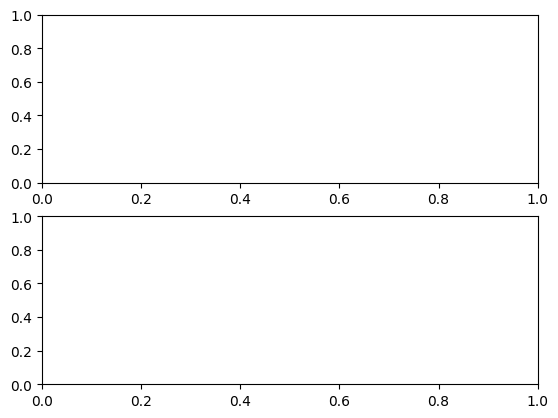

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_name = 'HybridSN'
net = HybridSN()
net.to(device=device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

loss_list = []
val_acc_list = []
val_epoch_list = []

epochs = 100
best_acc = 0.0
save_path = './{}Net.pth'.format(model_name)
train_steps = len(train_loader)
train_num = train_loader.dataset.__len__()
val_num = test_loader.dataset.__len__()

fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

for epoch in range(epochs):
    # train
    net.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, file=sys.stdout)

    for batch_idx, (inputs, labels) in enumerate(train_bar):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        train_bar.desc = 'train epoch[{}/{}] loss:{:.3f}'.format(epoch+1, epochs, loss)
    loss_list.append(running_loss/train_num)

    # validate,after train 5 times 
    if (epoch+1)%5==0 or (epoch+1)==epochs:
        acc = 0.0 # accumulate accurate number / epoch
        net.eval()
        with torch.no_grad():
            val_bar = tqdm(test_loader, file=sys.stdout)

            for batch_idx, (val_inputs, val_labels) in enumerate(val_bar):
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                outputs = net(val_inputs)
                predict_y = torch.max(outputs, dim=1)[1] # [1]我们只需要知道最大值所在的位置在哪里，也就是索引
                acc += torch.eq(predict_y, val_labels).sum().item()

        val_accurate = acc / val_num
        val_acc_list.append(val_accurate)
        val_epoch_list.append(epoch)
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
                (epoch + 1, running_loss / train_steps, val_accurate))
        
        # get best model
        if val_accurate > best_acc:
                best_acc = val_accurate
                torch.save(net.state_dict(), save_path)

ax1.plot(np.arange(epoch+1), loss_list, label='loss')
ax1.set_title('loss')
ax1.set_xlabel('epoch')
ax1.legend()

ax2.plot(val_epoch_list, val_acc_list, label = 'val_acc', c='orange')
ax2.set_title('acc')
ax2.set_xlabel('epoch')
ax2.legend()

print('Finished Training')

## 载入模型验证

### 生成分类报告

In [ ]:
model = HybridSN().to(device=device)
weights_path = save_path
assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
model.load_state_dict(torch.load(weights_path, map_location=device))

model.eval()
y_pred_test = []
for inputs, _ in test_loader:
    inputs = inputs.to(device)
    outputs = model(inputs)
    predicted = np.argmax(outputs.detach().cpu().numpy(), axis=1)
    y_pred_test.append(predicted)

y_pred_test = np.concatenate(y_pred_test)


classification = classification_report(ytest, y_pred_test, digits=4)
print(classification)

In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
def reports (test_loader,y_test,name):
    count = 0
    # 模型测试
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = net(inputs)
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        if count == 0:
            y_pred = outputs
            count = 1
        else:
            y_pred = np.concatenate((y_pred, outputs))

    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(y_test, y_pred, target_names=target_names)
    oa = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix((y_test, y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(y_test, y_pred)
    
    return classification, confusion, oa*100, each_acc*100, aa*100, kappa*100

In [ ]:
classification, confusion, oa, each_acc, aa, kappa = reports(test_loader, ytest, 'IP')
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

In [ ]:
with open(file_name, 'w') as x_file:
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+patch_size)
    width_slice = slice(width_index, width_index+patch_size)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [ ]:
# load the original image
X, y = loadData(dataset)

In [ ]:
height = y.shape[0]
width = y.shape[1]
patch_size = patch_size
numComponents = pca_components

In [ ]:
X,pca = applyPCA(X, numComponents=3)
X.shape

In [ ]:
X = padWithZeros(X, patch_size//2)
X.shape

In [ ]:
#逐像素预测图像类别
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2]).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))